##### 데이터 시각화할 때 한글 깨지면 실행할 코드 

In [ ]:
# 해당 셀 실행하고 런타임 다시시작 후 아래 셀 실행 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

## ◾ Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import datetime
from datetime import datetime
import calendar
from zipfile import ZipFile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## ◾ EDA 

##### [ 데이터 둘러보기 ] 

In [ ]:
#--------------- train: 총 28개 상추 케이스 ---------------#
train_path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/Dataset/"
all_train_input_list = sorted(glob.glob(train_path + 'train_input/*.csv'))
all_train_target_list = sorted(glob.glob(train_path + 'train_target/*.csv'))

train_input_df = pd.DataFrame()
train_target_df = pd.DataFrame()

for input_path, target_path in tqdm(zip(all_train_input_list, all_train_target_list)):
  input_df = pd.read_csv(input_path)
  target_df = pd.read_csv(target_path)
  train_input_df = pd.concat([train_input_df, input_df], axis=0, ignore_index=True) # 행방향(위아래)으로 데이터프레임을 이어붙임 
  train_target_df = pd.concat([train_target_df, target_df], axis=0, ignore_index=True) # 행방향(위아래)으로 데이터프레임을 이어붙임

print(train_input_df.shape, train_target_df.shape)

# train_input_df # 18816 rows(28*672) × 16 columns
# train_target_df # 784 rows(28*28) x 2 columns

0it [00:00, ?it/s]

(18816, 16) (784, 2)


In [ ]:
#--------------- test: 총 5개 상추 케이스 ---------------#
test_path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/Dataset/"
all_test_input_list = sorted(glob.glob(test_path + 'test_input/*.csv'))
all_test_target_list = sorted(glob.glob(test_path + 'test_target/*.csv'))

test_input_df = pd.DataFrame()
test_target_df = pd.DataFrame()

for input_path, target_path in tqdm(zip(all_test_input_list, all_test_target_list)):
  input_df = pd.read_csv(input_path)
  target_df = pd.read_csv(target_path)
  test_input_df = pd.concat([test_input_df, input_df], axis=0, ignore_index=True) # 행방향(위아래)으로 데이터프레임을 이어붙임 
  test_target_df = pd.concat([test_target_df, target_df], axis=0, ignore_index=True) # 행방향(위아래)으로 데이터프레임을 이어붙임

print(test_input_df.shape, test_target_df.shape)

# test_input_df # 3360 rows(5*672) × 16 columns
# test_target_df # 140 rows(5*28) x 2 columns

0it [00:00, ?it/s]

(3360, 16) (140, 2)


In [ ]:
#--------------- submission: Test 청경채 케이스 5개에 대한 일별 추론한 결과 ---------------#
zip_path = '/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/Dataset/sample_submission.zip'
extract_zip_folder_path = '/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/Dataset/sample_submission'

with ZipFile(zip_path, 'r') as zipObj:
    zipObj.extractall(extract_zip_folder_path)

submission_list = sorted(glob.glob(extract_zip_folder_path + '/*.csv'))

submission_df = pd.DataFrame()

for submission_path in tqdm(submission_list):
  df = pd.read_csv(submission_path)
  submission_df = pd.concat([submission_df, df], axis=0, ignore_index=True) # 행방향(위아래)으로 데이터프레임을 이어붙임 

print(submission_df.shape)

# submission_df # 140 rows(5*28) × 2 columns

  0%|          | 0/5 [00:00<?, ?it/s]

(140, 2)


In [ ]:
train_input_df.info() # 결측값 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18816 entries, 0 to 18815
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DAT       18816 non-null  int64  
 1   obs_time  18816 non-null  object 
 2   내부온도관측치   18816 non-null  float64
 3   내부습도관측치   18816 non-null  float64
 4   co2관측치    18816 non-null  float64
 5   ec관측치     18816 non-null  float64
 6   시간당분무량    18816 non-null  float64
 7   일간누적분무량   18816 non-null  float64
 8   시간당백색광량   18816 non-null  float64
 9   일간누적백색광량  18816 non-null  float64
 10  시간당적색광량   18816 non-null  float64
 11  일간누적적색광량  18816 non-null  float64
 12  시간당청색광량   18816 non-null  float64
 13  일간누적청색광량  18816 non-null  float64
 14  시간당총광량    18816 non-null  float64
 15  일간누적총광량   18816 non-null  float64
dtypes: float64(14), int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
train_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DAT                 784 non-null    int64  
 1   predicted_weight_g  784 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 12.4 KB


In [ ]:
test_input_df.info() # 결측값 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DAT       3360 non-null   int64  
 1   obs_time  3360 non-null   object 
 2   내부온도관측치   3360 non-null   float64
 3   내부습도관측치   3360 non-null   float64
 4   co2관측치    3360 non-null   float64
 5   ec관측치     3360 non-null   float64
 6   시간당분무량    3360 non-null   float64
 7   일간누적분무량   3360 non-null   float64
 8   시간당백색광량   3360 non-null   float64
 9   일간누적백색광량  3360 non-null   float64
 10  시간당적색광량   3360 non-null   float64
 11  일간누적적색광량  3360 non-null   float64
 12  시간당청색광량   3360 non-null   float64
 13  일간누적청색광량  3360 non-null   float64
 14  시간당총광량    3360 non-null   float64
 15  일간누적총광량   3360 non-null   float64
dtypes: float64(14), int64(1), object(1)
memory usage: 420.1+ KB


In [ ]:
test_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   DAT                 140 non-null    int64
 1   predicted_weight_g  140 non-null    int64
dtypes: int64(2)
memory usage: 2.3 KB


In [ ]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   DAT                 140 non-null    int64
 1   predicted_weight_g  140 non-null    int64
dtypes: int64(2)
memory usage: 2.3 KB


## ◾ Feature Engineering - 기본적인 것 
피처명 한글화, 측정시간 수정, 파생 피처 생성('상추')  


생각해보니 어짜피 input 데이터의 0일차 생육일 환경 데이터로 1일차 타깃값을 예측하고, 1일차 생육일 환경 데이터로 2일차 타깃값을 예측하기 때문에 0을 드롭할 필요도 없고, 0으로 채운 행을 또 추가할 필요도 진작에 없었다.  
그냥 이 대회의 핵심은 적절한 피처 추출과 모델선택 그리고 하이퍼파라미터 튜닝인가보다.. 

##### [ 피처명 한글화 ]

In [ ]:
train_input_df = train_input_df.rename(columns={'DAT': '생육일',
                                                'obs_time': '측정시간'})

train_input_df.head()

,생육일,측정시간,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,01:00,25.680357,81.264286,528.696429,1.409003,126.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,02:00,25.273333,81.471666,532.833333,1.406913,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,03:00,25.355000,81.398334,545.566667,1.406689,126.0,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,04:00,25.391667,81.483333,558.583333,1.411070,0.0,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_input_df = test_input_df.rename(columns={'DAT': '생육일',
                                              'obs_time': '측정시간'})

test_input_df.head()

,생육일,측정시간,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,26.260000,60.103333,471.883333,1.028971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,01:00,26.511864,59.930509,472.500000,1.030566,769.0,769.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,02:00,25.890000,59.745000,472.850000,1.034274,0.0,769.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,03:00,25.871666,60.023334,476.666667,1.034595,769.0,1538.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,04:00,26.356667,60.150000,468.833333,1.035417,0.0,1538.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_target_df = train_target_df.rename(columns={'DAT': '생육일',
                                                  'predicted_weight_g': '생육일별_잎_중량'})

train_target_df.head()

,생육일,생육일별_잎_중량
0,1,0.167719
1,2,0.181787
2,3,0.265921
3,4,0.423650
4,5,0.475272


In [ ]:
test_target_df = test_target_df.rename(columns={'DAT': '생육일',
                                                'predicted_weight_g': '생육일별_잎_중량'})

test_target_df.head()

,생육일,생육일별_잎_중량
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


##### [ 측정시간 수정 ]  
'14:59:59' -> '15:00:00'으로 바꾼 후 진행해야 함
(초단위가 59면 1초씩 더함)

In [ ]:
train_input_df.loc[train_input_df['측정시간'].astype(str).str.len()!=5].index   

Int64Index([  672,   673,   674,   675,   676,   677,   678,   679,   680,
              681,
            ...
            17462, 17463, 17464, 17465, 17466, 17467, 17468, 17469, 17470,
            17471],
           dtype='int64', length=4704)

In [ ]:
#--------------- train 총 28개 상추 케이스 ---------------#
import datetime

train_input_df['측정시간'] = train_input_df['측정시간'].str.replace(".", "") #"00:00:00." -> "00:00:00"
plus_one_second = datetime.timedelta(seconds=1)

for i in tqdm(range(len(train_input_df['측정시간']))):
  if len(train_input_df['측정시간'][i]) < 6: #"00:00" 형식
    train_input_df['측정시간'][i] = train_input_df['측정시간'][i] + ":00"
  train_input_df['측정시간'][i] = pd.to_datetime(train_input_df['측정시간'][i], format='%H:%M:%S')
  # 초단위가 59면 1초씩 더함 
  str_time = str(train_input_df['측정시간'][i])
  if str_time[-2:] == '59':
    train_input_df['측정시간'][i] = train_input_df['측정시간'][i] + plus_one_second

train_input_df['측정시간'] = pd.to_datetime(train_input_df['측정시간'])
train_input_df['측정시간'] = train_input_df['측정시간'].dt.hour #시

train_input_df = train_input_df.reset_index() 
train_input_df = train_input_df.drop(['index'], axis=1) 

train_input_df # 18816 rows × 16 columns

  0%|          | 0/18816 [00:00<?, ?it/s]

,생육일,측정시간,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,27,19,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,0.0,22253.7504,0.0,10462.6535,12.3764,179438.6259
18812,27,20,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18813,27,21,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18814,27,22,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259


In [ ]:
#--------------- test 총 5개 상추 케이스 ---------------#
import datetime

test_input_df['측정시간'] = test_input_df['측정시간'].str.replace(".", "") #"00:00:00." -> "00:00:00"
plus_one_second = datetime.timedelta(seconds=1)

for i in tqdm(range(len(test_input_df['측정시간']))):
  if len(test_input_df['측정시간'][i]) < 6: #"00:00" 형식
    test_input_df['측정시간'][i] = test_input_df['측정시간'][i] + ":00"
  test_input_df['측정시간'][i] = pd.to_datetime(test_input_df['측정시간'][i], format='%H:%M:%S')
  # 초단위가 59면 1초씩 더함 
  str_time = str(test_input_df['측정시간'][i])
  if str_time[-2:] == '59':
    test_input_df['측정시간'][i] = test_input_df['측정시간'][i] + plus_one_second

test_input_df['측정시간'] = pd.to_datetime(test_input_df['측정시간'])
test_input_df['측정시간'] = test_input_df['측정시간'].dt.hour #시

test_input_df = test_input_df.reset_index() 
test_input_df = test_input_df.drop(['index'], axis=1) 

test_input_df # 3360 rows × 16 columns

  0%|          | 0/3360 [00:00<?, ?it/s]

,생육일,측정시간,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,0,26.260000,60.103333,471.883333,1.028971,0.00,0.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
1,0,1,26.511864,59.930509,472.500000,1.030566,769.00,769.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
2,0,2,25.890000,59.745000,472.850000,1.034274,0.00,769.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
3,0,3,25.871666,60.023334,476.666667,1.034595,769.00,1538.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
4,0,4,26.356667,60.150000,468.833333,1.035417,0.00,1538.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,27,19,24.478333,59.196667,442.383333,0.916185,0.00,2594.56,6.1882,146712.9397,0.0,22242.1668,0.0,10457.954,6.1882,179413.0605
3356,27,20,24.636667,58.330000,439.733333,0.916925,80.99,2675.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605
3357,27,21,24.103333,57.768333,434.516667,0.916777,0.00,2675.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605
3358,27,22,23.888333,57.255000,427.633333,0.918006,126.00,2801.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605


##### [ 파생 피처 생성 ('상추') ]  
train_input_df, train_target_df, test_input_df, test_target_df 모두

In [ ]:
#--------------- train 총 28개 상추 케이스 ---------------#

#--- train_input_df에 28개의 상추 구분을 위한 '상추' Feature 추가
train_input_df['상추'] = "NaN"
train_input_df = train_input_df[[
       '생육일', '측정시간', '상추', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량']]

for idx in range(28):
  train_input_df['상추'][672*idx:672*(idx+1)] = 'case' + str(idx+1)

train_input_df # 18816 rows × 17 columns

# train_input_df[(train_input_df['상추']=='case10')&(train_input_df['측정시간']==0)] # 제대로 추가됐는지 확인

,생육일,측정시간,상추,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,0,case1,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
1,0,1,case1,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
2,0,2,case1,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
3,0,3,case1,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
4,0,4,case1,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,27,19,case28,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,0.0,22253.7504,0.0,10462.6535,12.3764,179438.6259
18812,27,20,case28,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18813,27,21,case28,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18814,27,22,case28,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259


In [ ]:
#--- train_target_df 28개의 상추 구분을 위한 '상추' Feature 추가
train_target_df['상추'] = "NaN"
train_target_df = train_target_df[[
       '생육일', '생육일별_잎_중량', '상추']]

for idx in range(28):
  train_target_df['상추'][28*idx:28*(idx+1)] = 'case' + str(idx+1)

train_target_df # 784 rows × 3 columns

# train_target_df[(train_target_df['상추']=='case10')&(train_target_df['측정시간']==0)] # 제대로 추가됐는지 확인

,생육일,생육일별_잎_중량,상추
0,1,0.167719,case1
1,2,0.181787,case1
2,3,0.265921,case1
3,4,0.423650,case1
4,5,0.475272,case1
...,...,...,...
779,24,64.875499,case28
780,25,74.002614,case28
781,26,76.342275,case28
782,27,82.621245,case28


In [ ]:
#--------------- test 총 5개 상추 케이스 ---------------#

#--- test_input_df에 5개의 상추 구분을 위한 '상추' Feature 추가
test_input_df['상추'] = "NaN"
test_input_df = test_input_df[[
       '생육일', '측정시간', '상추', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량']]

for idx in range(28):
  test_input_df['상추'][672*idx:672*(idx+1)] = 'case' + str(idx+1+28) # test_input_df 뒤에 붙일거기 때문에 case28~case32 이어야 함. 

test_input_df # 3360 rows × 17 columns

# test_input_df[(test_input_df['상추']=='case10')&(test_input_df['측정시간']==0)] # 제대로 추가됐는지 확인

,생육일,측정시간,상추,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,0,case29,26.260000,60.103333,471.883333,1.028971,0.00,0.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
1,0,1,case29,26.511864,59.930509,472.500000,1.030566,769.00,769.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
2,0,2,case29,25.890000,59.745000,472.850000,1.034274,0.00,769.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
3,0,3,case29,25.871666,60.023334,476.666667,1.034595,769.00,1538.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
4,0,4,case29,26.356667,60.150000,468.833333,1.035417,0.00,1538.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,27,19,case33,24.478333,59.196667,442.383333,0.916185,0.00,2594.56,6.1882,146712.9397,0.0,22242.1668,0.0,10457.954,6.1882,179413.0605
3356,27,20,case33,24.636667,58.330000,439.733333,0.916925,80.99,2675.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605
3357,27,21,case33,24.103333,57.768333,434.516667,0.916777,0.00,2675.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605
3358,27,22,case33,23.888333,57.255000,427.633333,0.918006,126.00,2801.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605


In [ ]:
#--- test_target_df 28개의 상추 구분을 위한 '상추' Feature 추가
test_target_df['상추'] = "NaN"
test_target_df = test_target_df[[
       '생육일', '생육일별_잎_중량', '상추']]

for idx in range(28):
  test_target_df['상추'][28*idx:28*(idx+1)] = 'case' + str(idx+1+28)

test_target_df # 140 rows × 3 columns

# test_target_df[(test_target_df['상추']=='case10')&(test_target_df['측정시간']==0)] # 제대로 추가됐는지 확인

,생육일,생육일별_잎_중량,상추
0,1,0,case29
1,2,0,case29
2,3,0,case29
3,4,0,case29
4,5,0,case29
...,...,...,...
135,24,0,case33
136,25,0,case33
137,26,0,case33
138,27,0,case33


In [ ]:
input_columns_list = ['상추', '생육일', '측정시간', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량']

target_columns_list = ['상추', '생육일', '생육일별_잎_중량']

In [ ]:
train_input_df = train_input_df[input_columns_list]
test_input_df = test_input_df[input_columns_list]

train_target_df = train_target_df[target_columns_list]
test_target_df = test_target_df[target_columns_list]

## ◾시각화

##### [ train_input_df 개별 피처 탐색 ]

'내부온도관측치', '내부습도관측치',  
'co2관측치', 'ec관측치',  
'시간당분무량','일간누적분무량',  
'시간당백색광량', '일간누적백색광량',  
'시간당적색광량', '일간누적적색광량',  
'시간당청색광량', '일간누적청색광량',  
'시간당총광량', '일간누적총광량'  

In [ ]:
train_input_df

,상추,생육일,측정시간,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,case1,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
1,case1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
2,case1,0,2,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
3,case1,0,3,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
4,case1,0,4,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,case28,27,19,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,0.0,22253.7504,0.0,10462.6535,12.3764,179438.6259
18812,case28,27,20,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18813,case28,27,21,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18814,case28,27,22,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259


In [ ]:
train_input_df.columns

Index(['상추', '생육일', '측정시간', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량'],
      dtype='object')

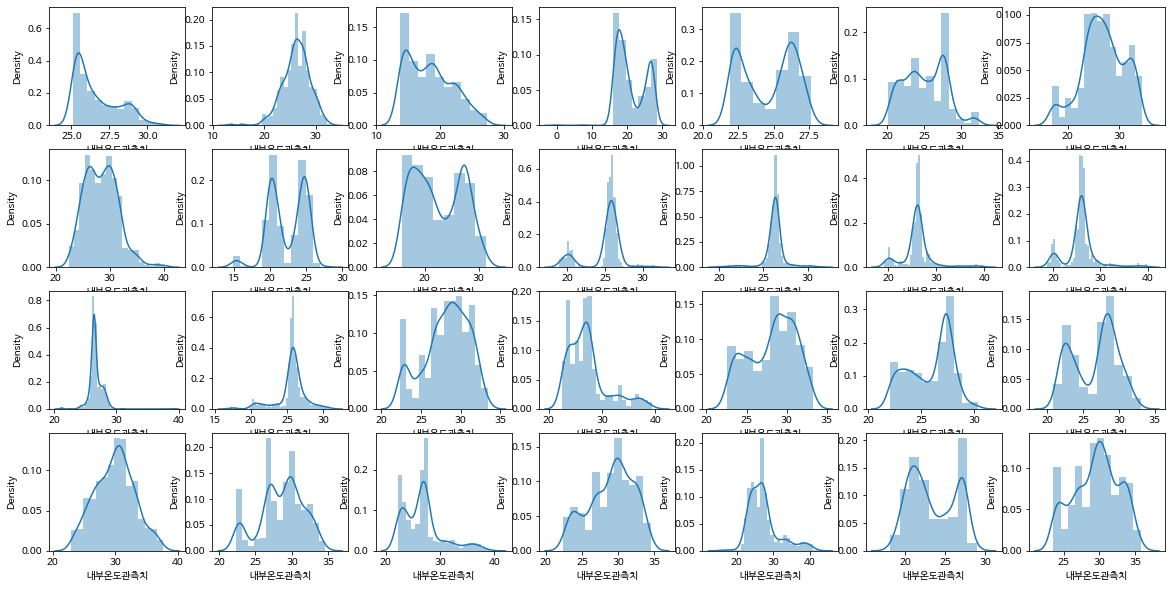

In [ ]:
# 내부온도관측치

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['내부온도관측치'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

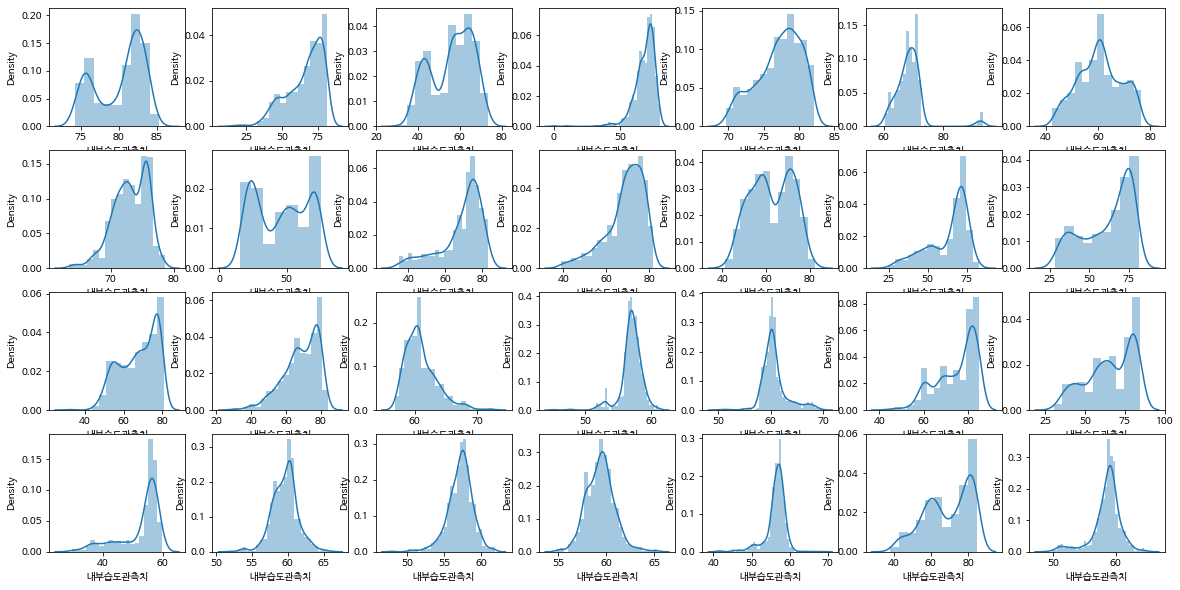

In [ ]:
# 내부습도관측치

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['내부습도관측치'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

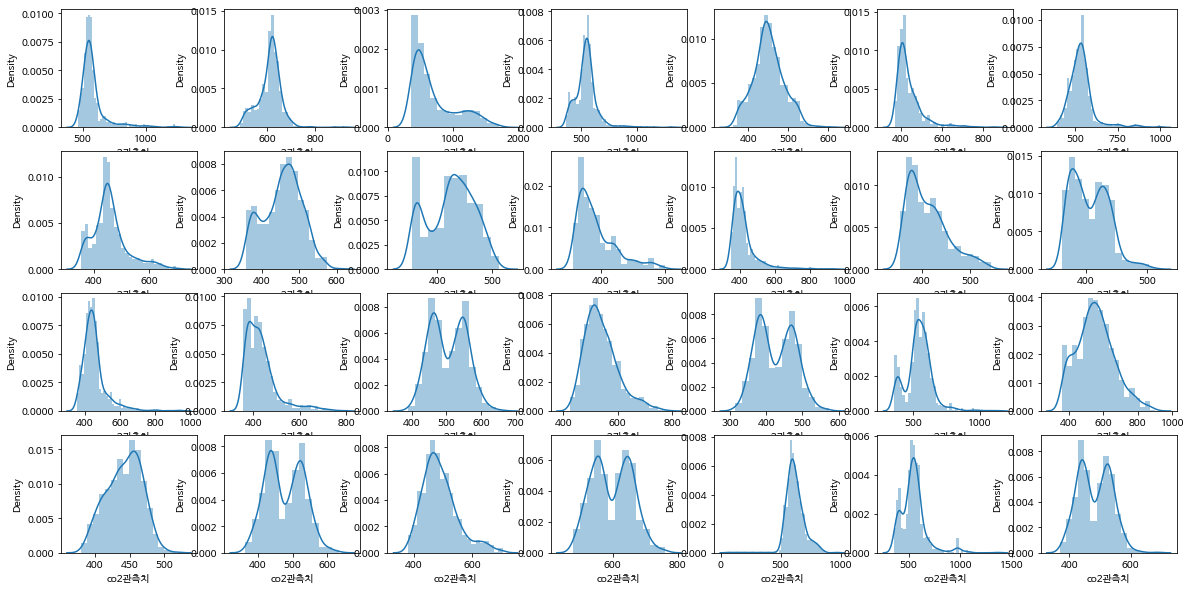

In [ ]:
# co2관측치

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['co2관측치'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

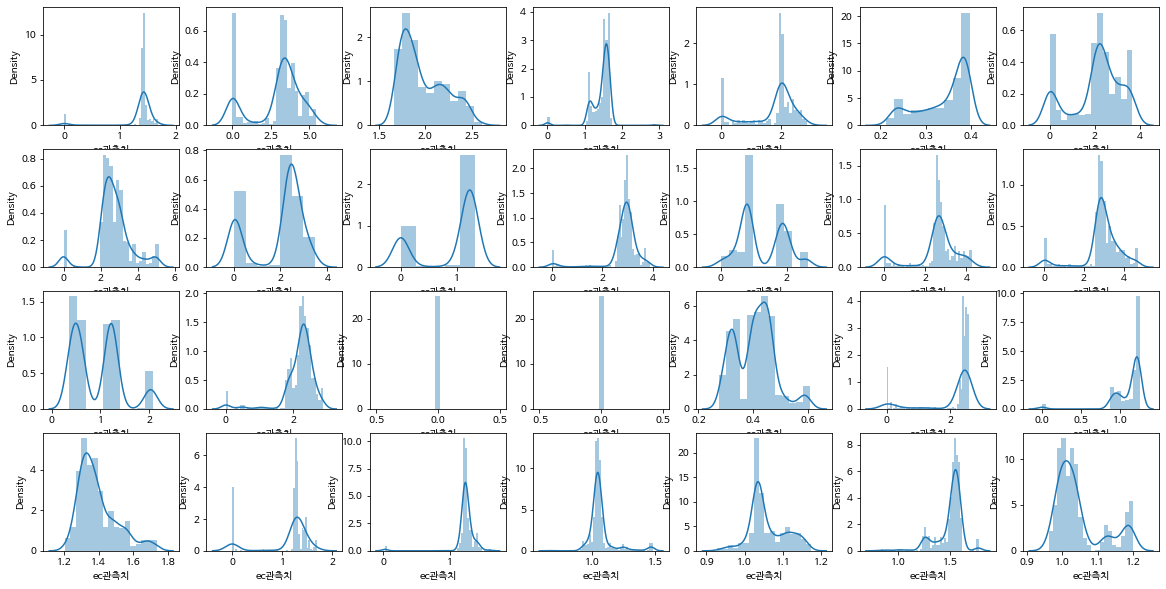

In [ ]:
# ec관측치

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['ec관측치'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

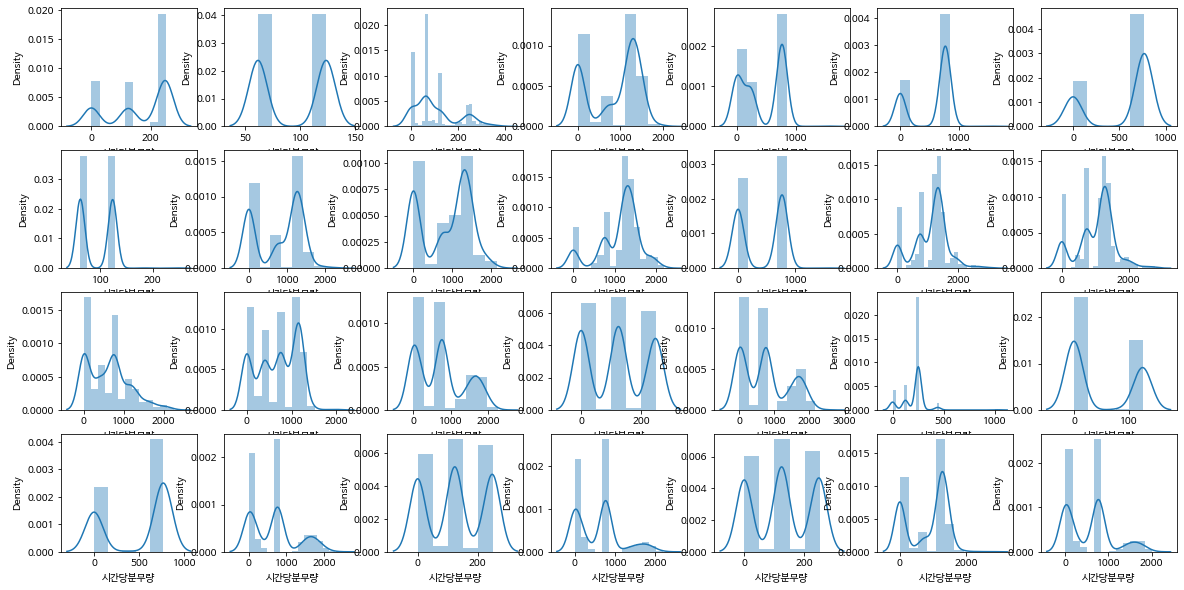

In [ ]:
# 시간당분무량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['시간당분무량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

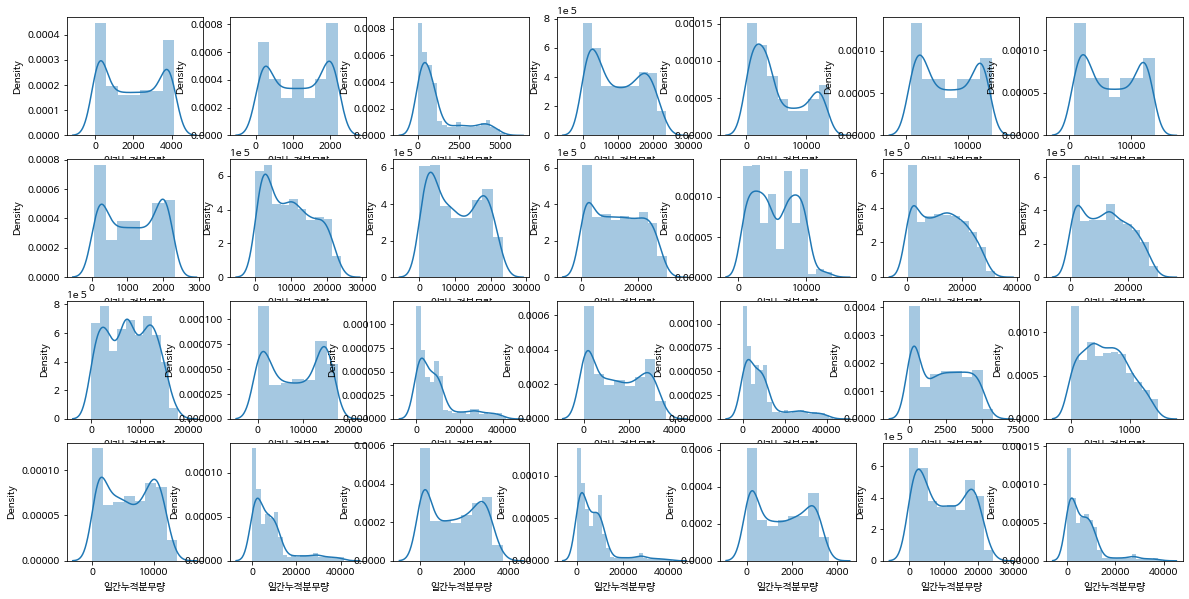

In [ ]:
# 일간누적분무량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['일간누적분무량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

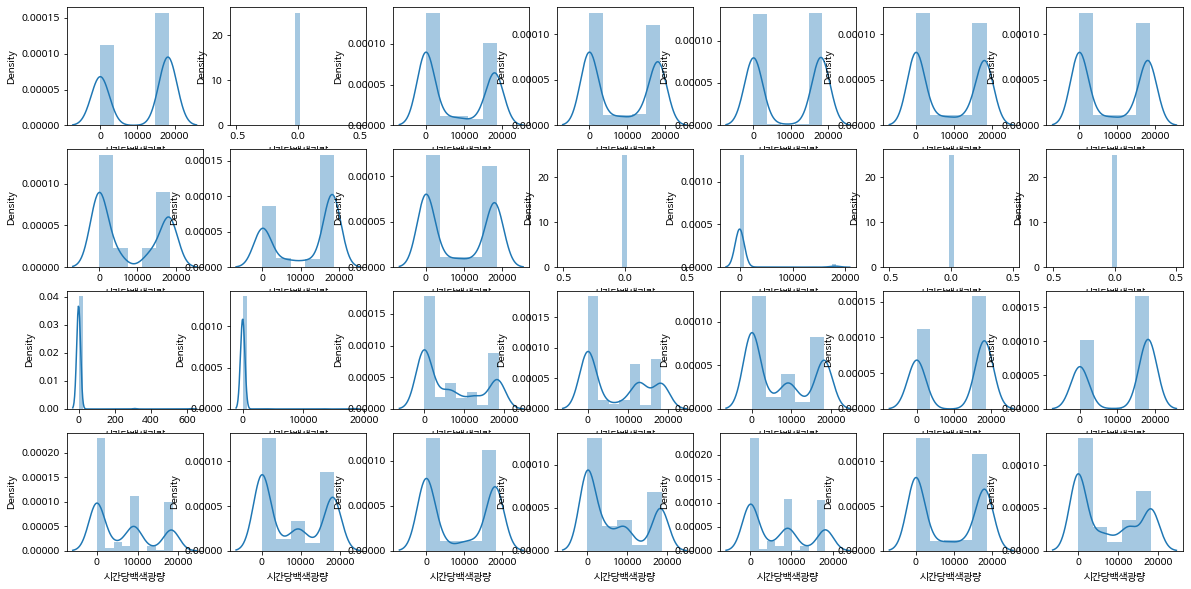

In [ ]:
# 시간당백색광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['시간당백색광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

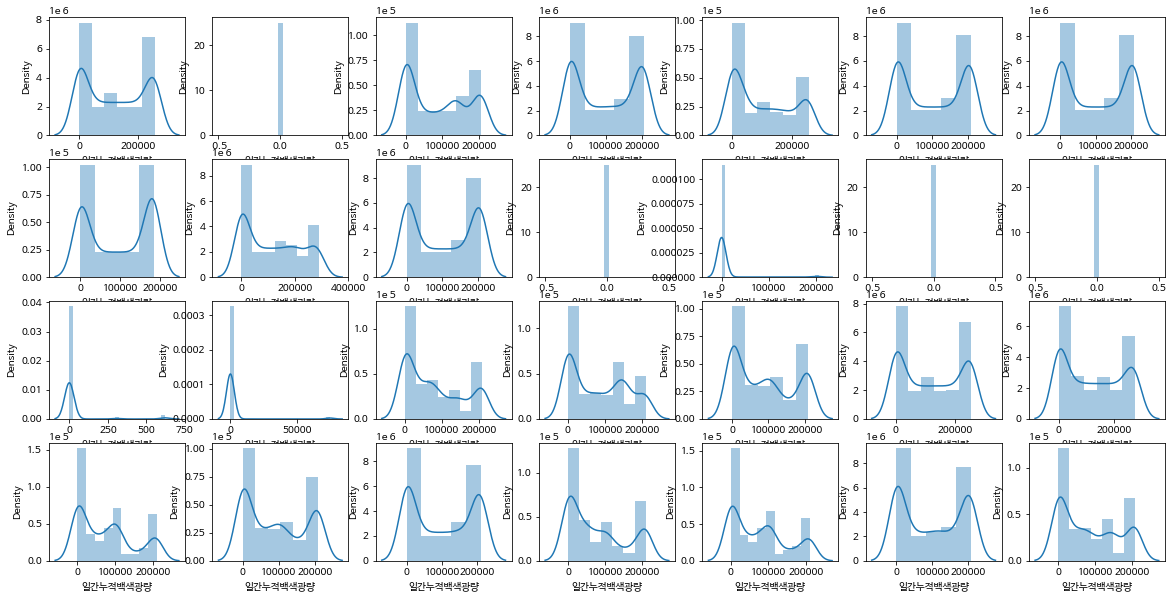

In [ ]:
# 일간누적백색광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['일간누적백색광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

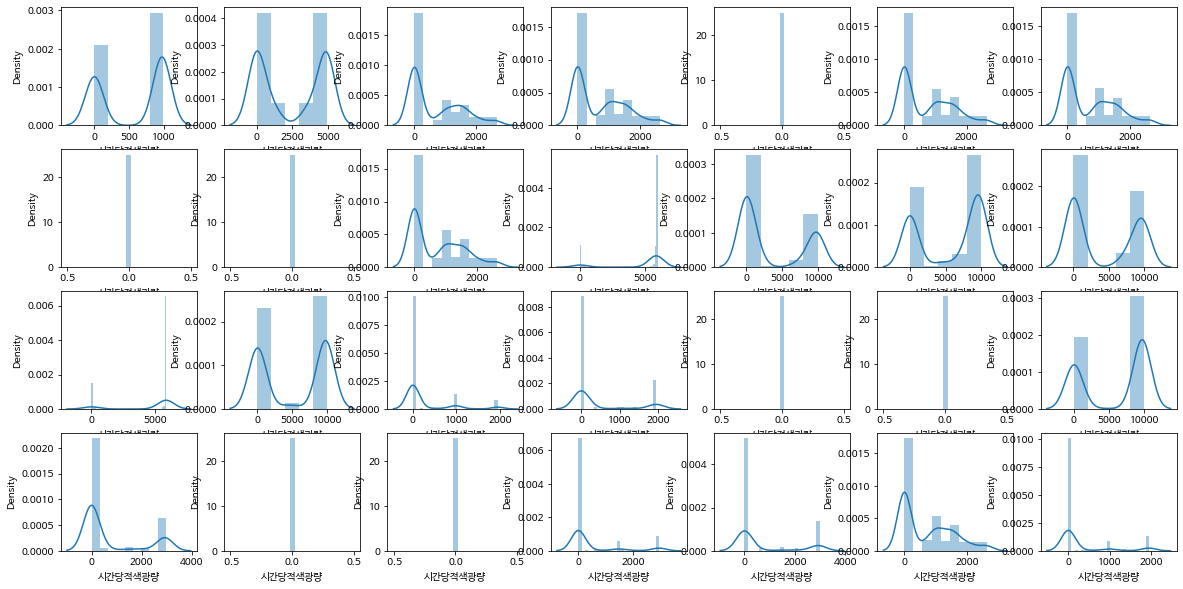

In [ ]:
# 시간당적색광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['시간당적색광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

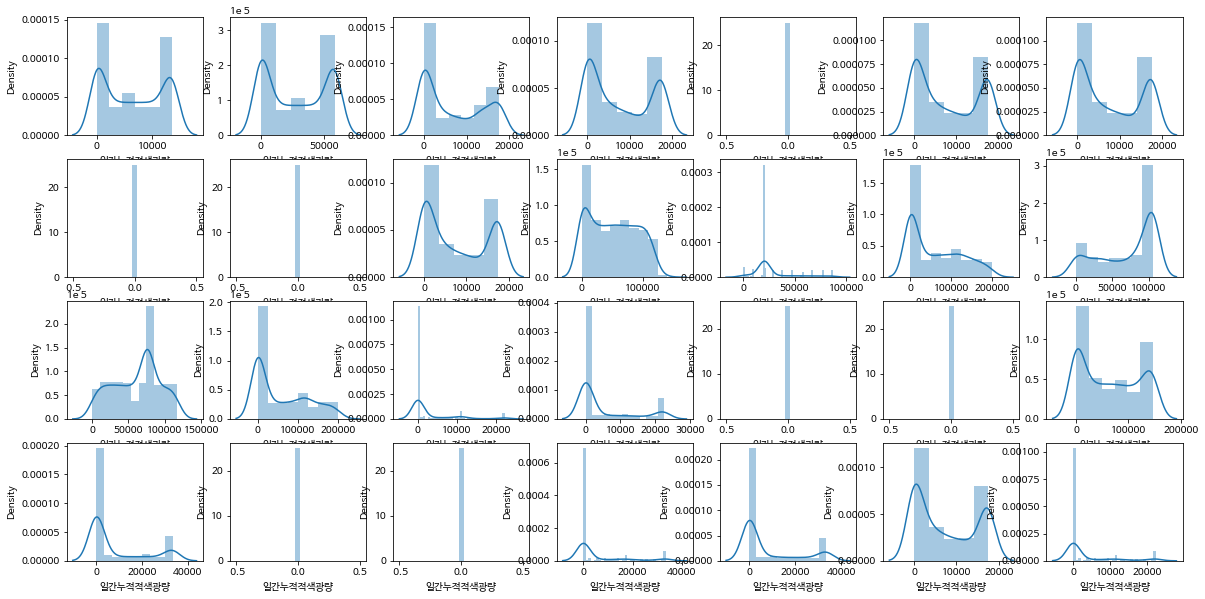

In [ ]:
# 일간누적적색광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['일간누적적색광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

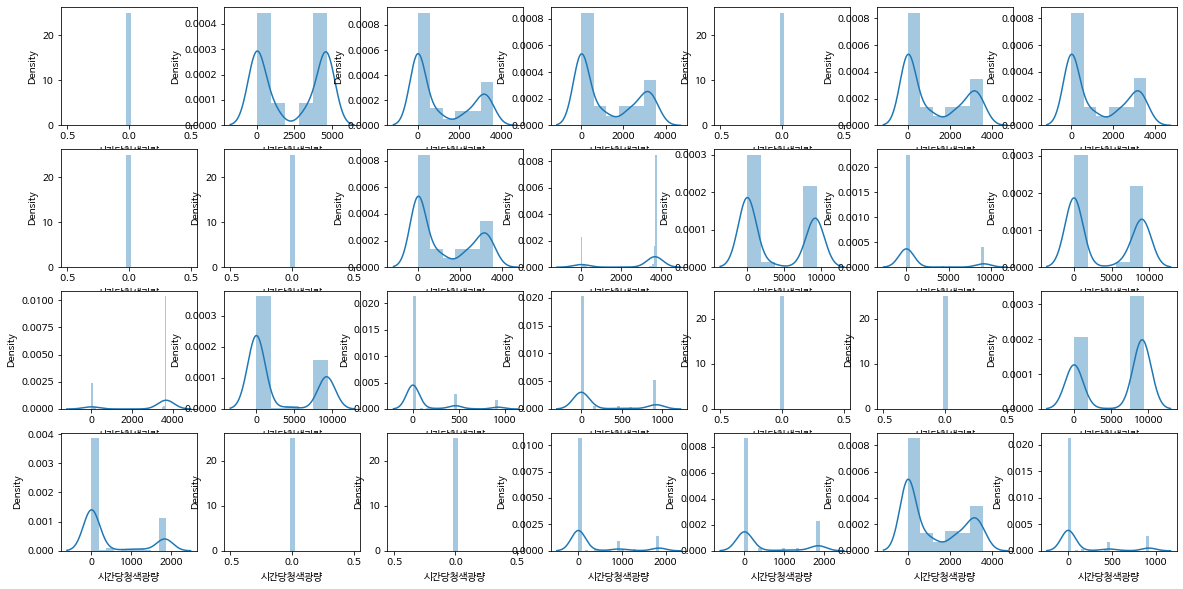

In [ ]:
# 시간당청색광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['시간당청색광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

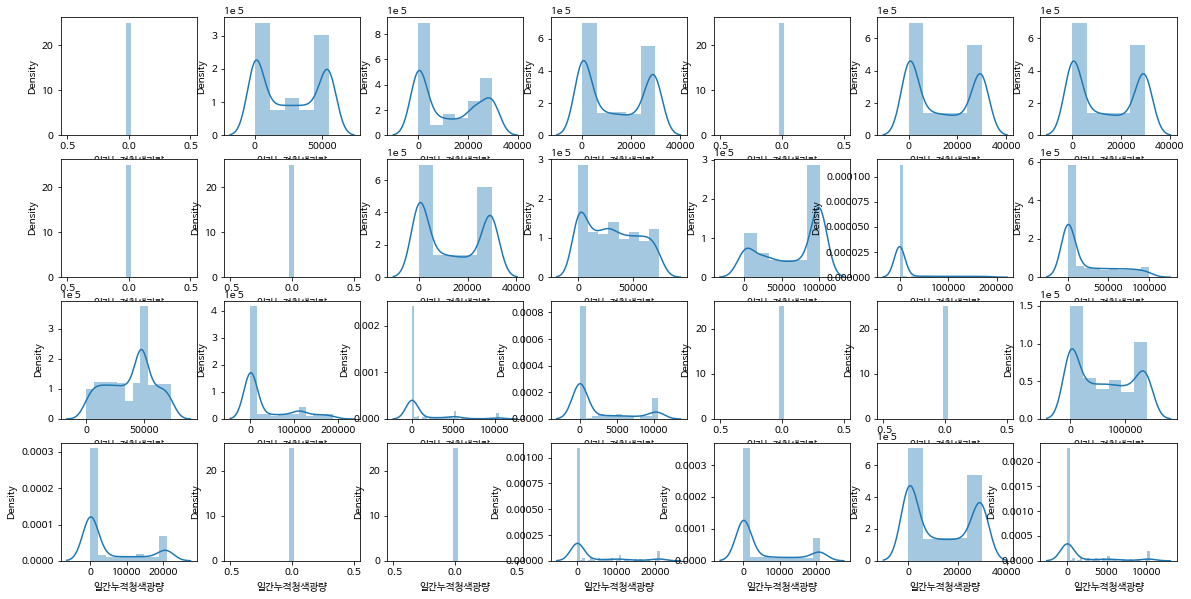

In [ ]:
# 일간누적청색광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['일간누적청색광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

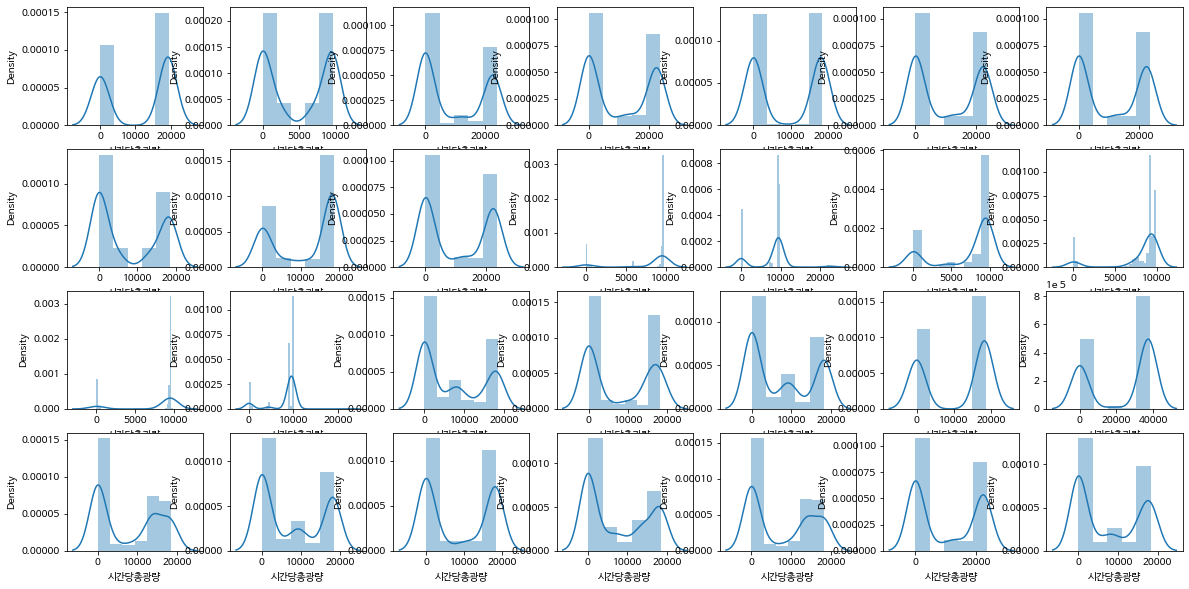

In [ ]:
# 시간당총광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['시간당총광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

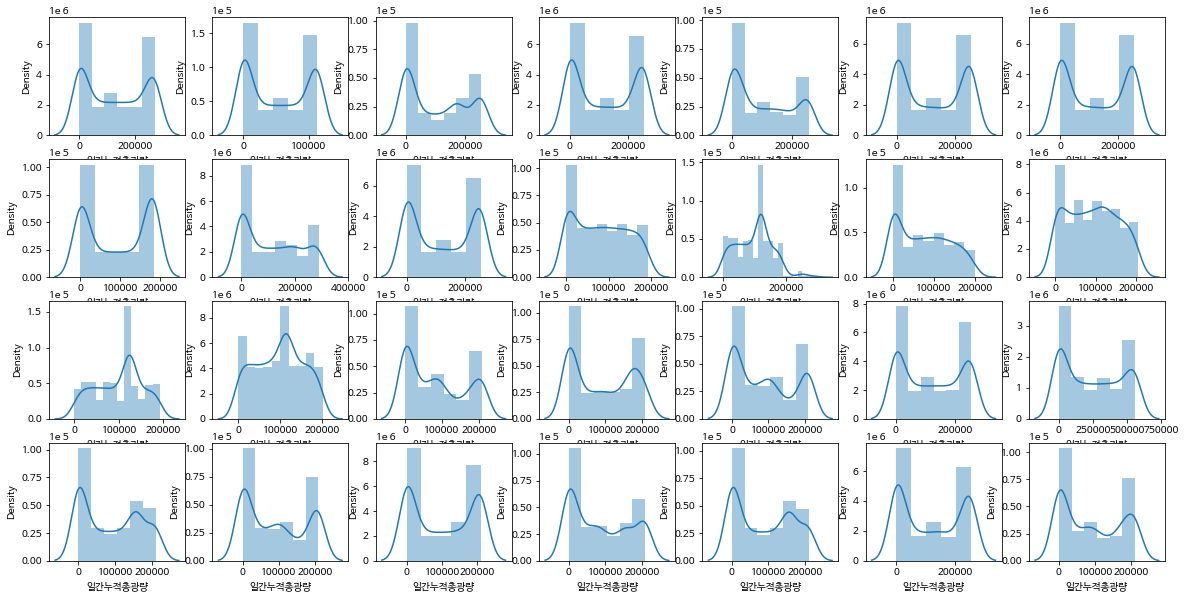

In [ ]:
# 일간누적총광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['일간누적총광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

##### [ train_targe_df '생육일별잎중량' 피처 탐색 ] 

In [ ]:
train_target_df

,상추,생육일,생육일별_잎_중량
0,case1,1,0.167719
1,case1,2,0.181787
2,case1,3,0.265921
3,case1,4,0.423650
4,case1,5,0.475272
...,...,...,...
779,case28,24,64.875499
780,case28,25,74.002614
781,case28,26,76.342275
782,case28,27,82.621245


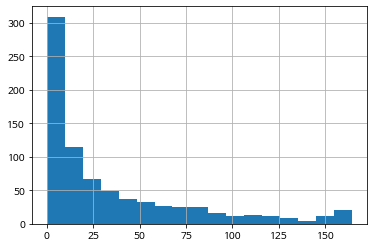

In [ ]:
# 생육일별_잎_중량의 분포를 그래프로 탐색
train_target_df['생육일별_잎_중량'].hist(bins="auto")

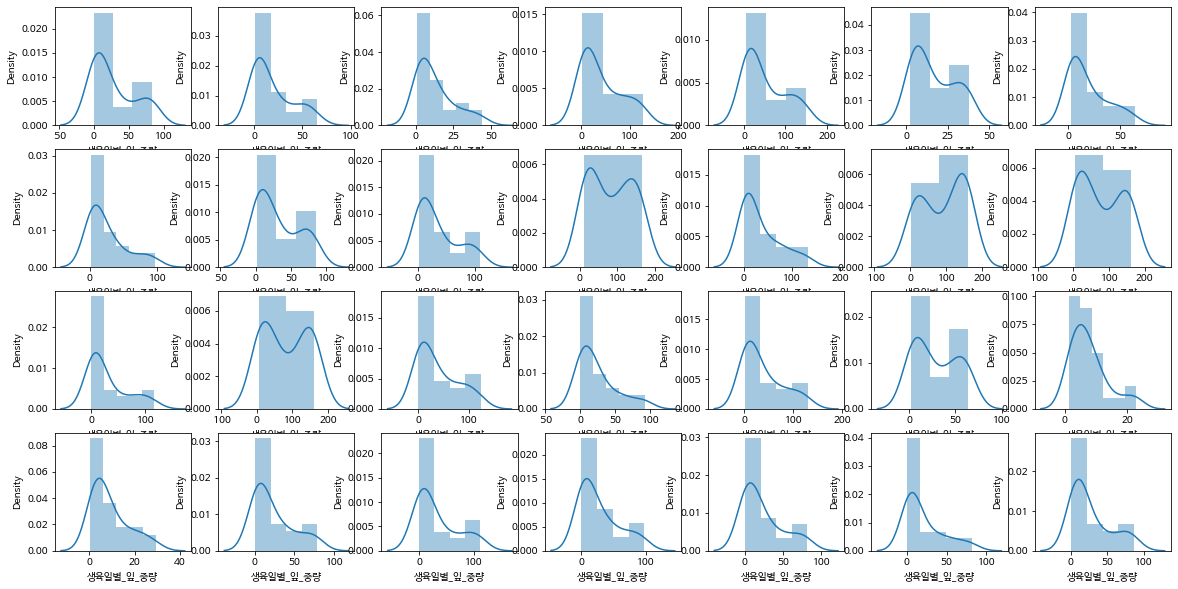

In [ ]:
# 생육일별_잎_중량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_target_df.loc[train_target_df['상추']=='case'+str(case_idx+1)]['생육일별_잎_중량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

In [ ]:
# 상추(case)별 생육일별_잎_중량의 평균과 표준편차를 계산합니다.

case_target_model_mean = train_target_df.groupby('상추')['생육일별_잎_중량'].transform(lambda x: np.mean(x))
case_target_model_std = train_target_df.groupby('상추')['생육일별_잎_중량'].transform(lambda x: np.std(x))

In [ ]:
case_target_model_mean

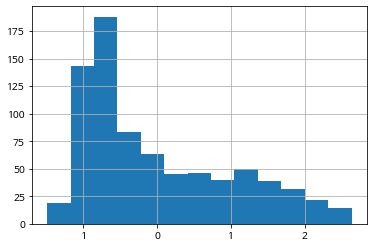

In [ ]:
# 이를 바탕으로 모든 데이터의 z-score를 계산합니다. 이는 해당 데이터의 가격이 상추별 평균에 비해 어느정도로 높거나 낮은지를 알 수 있게 하는 점수입니다.
case_target_model_z_score = (train_target_df['생육일별_잎_중량'] - case_target_model_mean) / case_target_model_std
case_target_model_z_score.hist(bins="auto")

##### [ train_input_df 피처들을 수치 갯수, 데이터 갯수 순으로 정렬하여 막대그래프 그리기 ]

In [ ]:
train_input_df

,상추,생육일,측정시간,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,case1,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
1,case1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
2,case1,0,2,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
3,case1,0,3,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
4,case1,0,4,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,case28,27,19,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,0.0,22253.7504,0.0,10462.6535,12.3764,179438.6259
18812,case28,27,20,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18813,case28,27,21,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18814,case28,27,22,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259


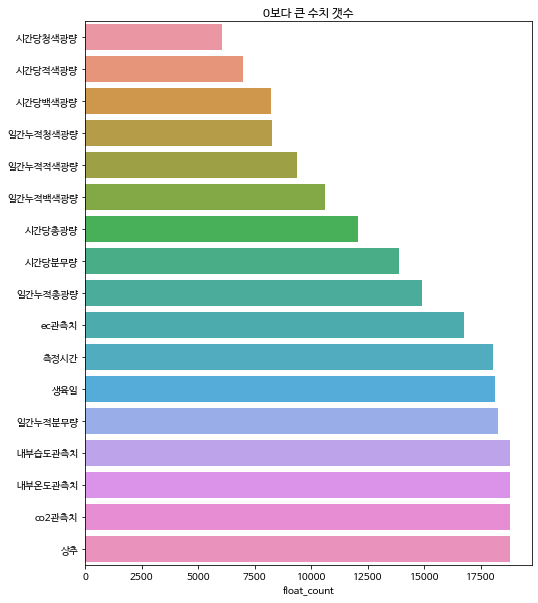

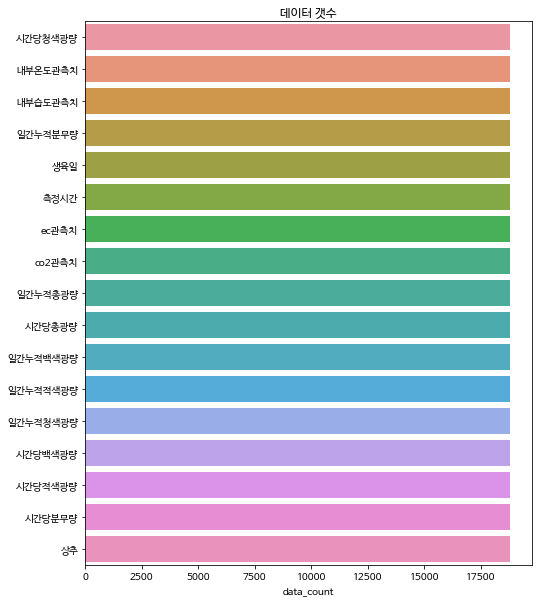

In [ ]:
# train_x, train_y = LoadData('train').read_train_raw()                           # train데이터를 전처리 없이 읽어온다.

data_count = (train_input_df.isnull()==False).sum()
null_count = (train_input_df.isnull()==True).sum()
float_count = (train_input_df.fillna(0).astype(bool)).sum()
data = [null_count, float_count, data_count]
index = ['null_count','float_count','data_count']
df = pd.DataFrame(data=data, index=index).T

df = df.sort_values('float_count')                                              # 수치 갯수 순으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('0보다 큰 수치 갯수')
sns.barplot(y=df.index, x=df['float_count'])                                    # 막대그래프를 그린다.
plt.show()

df = df.sort_values('data_count')                                               # 데이터 갯수 기준으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('데이터 갯수')
sns.barplot(y=df.index, x=df['data_count'])                                     # 막대그래프를 그린다.
plt.show()

##### [ train_input_df의 case별 피처들의 하루 24시간 변화량 살펴보기 ]

In [ ]:
FEATURES = train_input_df.columns

In [ ]:
FEATURES

Index(['상추', '생육일', '측정시간', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량'],
      dtype='object')

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

for i in range(1, 29):
  train_case = train_input_df.loc[train_input_df['상추']=='case'+str(i)]

  SAMPLE_NUM = 24
  COLS = FEATURES[3:]
  fig = make_subplots(rows=len(COLS), cols=1, subplot_titles=COLS)
  for row, col in enumerate(COLS, 1):
      fig.add_trace(go.Scatter(x=np.arange(SAMPLE_NUM), y=train_case[col].iloc[:SAMPLE_NUM], showlegend=False,
                          mode='lines+markers', name=col, marker=dict(color="orange")), row=row, col=1)

  fig.update_layout(height=5000, width=1000, title_text='case'+str(i))
  fig.show()

## ◾ Data Pre-processing

##### [ train_input_df 잘못된 값 변경(음수 -> 다른 값으로 변경) ]  


In [ ]:
def resumetable(df):
    print(f'train dataset 피처 요약표: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['최소값'] = df.min().values
    summary['최대값'] = df.max().values
    
    return summary

In [ ]:
resumetable(train_input_df)

train dataset 피처 요약표: (18816, 17)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,최소값,최대값
0,상추,object,0,28,case1,case1,case1,case9
1,생육일,int64,0,28,0,0,0,27
2,측정시간,int64,0,24,0,1,0,23
3,내부온도관측치,float64,0,17416,25.3,25.680357,0.0,42.643334
4,내부습도관측치,float64,0,17964,81.835,81.264286,0.0,93.350002
5,co2관측치,float64,0,14246,536.016667,528.696429,60.4,1714.85
6,ec관측치,float64,0,16306,1.407439,1.409003,0.0,5.462324
7,시간당분무량,float64,0,1886,0.0,126.0,-653.26,3144.13
8,일간누적분무량,float64,0,6013,0.0,126.0,0.0,42855.23
9,시간당백색광량,float64,0,1146,0.0,0.0,-138371.2461,18564.6


환경 변수 별 제한 범위 정보

*   시간당 내부 평균온도: 4도~40도  
*   시간당 내부 평균습도: 0% ~ 100%  
*   시간당 내부 평균 co2 농도 : 0ppm ~ 1200 ppm  
*   시간당 평균 EC : 0 ~ 8  
*   시간당 분무량 : 0 ~ 3000 / 일간 누적 분무량 0 ~ 72,000  
*   시간당 백색광량 : 0 ~ 120,000 / 일간 누적 백색광량 0 ~ 2,880,000  
*   시간당 적색광량 : 0 ~ 120,000 / 일간 누적 적색광량 0 ~ 2,880,000  
*   시간당 청색광량 : 0 ~ 120,000 / 일간 누적 청색광량 0 ~ 2,880,000  
*   시간당 총광량 : 0 ~ 120,000 / 일간 누적 총광량 0 ~ 2,880,000  

In [ ]:
train_input_df[train_input_df['시간당분무량']<0]

,상추,생육일,측정시간,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
8665,case13,25,1,19.825532,54.6,495.234043,1.251707,-537.52,0.0,0.0,0.0,0.0,0.0,0.0,469.95,0.0,469.95
8713,case13,27,1,19.825532,54.6,495.234043,3.006822,-653.26,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00


In [ ]:
# # 시간당분무량 음수 -> 양수
# # 24.0129729416 -> 24.0204320553로 더 내려감

# # train_input_df[train_input_df['시간당분무량']<0].index  # [8665, 8713]
# train_input_df['시간당분무량'].loc[[8665, 8713]] = -train_input_df['시간당분무량'].loc[[8665, 8713]]
# train_input_df.loc[[8665, 8713]]

# # 일간누적분무량 다시 구하기 
# for idx in tqdm(range(644)): # 644
#     time_series = train_input_df[24*idx:24*(idx+1)]['시간당분무량']
#     train_input_df[24*idx:24*(idx+1)]['일간누적분무량'] = time_series.cumsum()

In [ ]:
# 시간당분무량 음수 -> 0
# 23.7950618671로 올라감 

# train_input_df[train_input_df['시간당분무량']<0].index  # [8665, 8713]
train_input_df['시간당분무량'].loc[[8665, 8713]] = 0
train_input_df.loc[[8665, 8713]]

# 일간누적분무량 다시 구하기 
for idx in tqdm(range(644)): # 644
    time_series = train_input_df[24*idx:24*(idx+1)]['시간당분무량']
    train_input_df[24*idx:24*(idx+1)]['일간누적분무량'] = time_series.cumsum()

  0%|          | 0/644 [00:00<?, ?it/s]

In [ ]:
# 시간당백색광량
# 다른 case 살펴보고 그 시간대에 늘어난 양만큼 비슷하게 숫자 정함

# train_input_df[train_input_df['시간당백색광량']<0] # 3375
train_input_df['시간당백색광량'].loc[[3375]] = 17744.6635 # 혹은 18255.1900	
train_input_df.loc[[3375]]

# 일간누적백색광량 다시 구하기 
for idx in tqdm(range(644)): # 644
    time_series = train_input_df[24*idx:24*(idx+1)]['시간당백색광량']
    train_input_df[24*idx:24*(idx+1)]['일간누적백색광량'] = time_series.cumsum()

  0%|          | 0/644 [00:00<?, ?it/s]

In [ ]:
# 시간당적색광량 
# 다른 case 살펴보고 그 시간대에 늘어난 양만큼 비슷하게 숫자 정함

# train_input_df[train_input_df['시간당적색광량']<0] # 3375
train_input_df['시간당적색광량'].loc[[3375]] = 1859.7644	 # 1659.7644에서 임의로 200 더함	(1659.7644는 3374행의 값 )
train_input_df.loc[[3375]]

# 일간누적적색광량 다시 구하기 
for idx in tqdm(range(644)): # 644
    time_series = train_input_df[24*idx:24*(idx+1)]['시간당적색광량']
    train_input_df[24*idx:24*(idx+1)]['일간누적적색광량'] = time_series.cumsum()

  0%|          | 0/644 [00:00<?, ?it/s]

In [ ]:
# 시간당청색광량 
# 다른 case 살펴보고 그 시간대에 늘어난 양만큼 비슷하게 숫자 정함

# train_input_df[train_input_df['시간당청색광량']<0] # 3375
train_input_df['시간당청색광량'].loc[[3375]] = 3519.6695	 # 3419.6695에서 임의로 100 더함	(3419.6695는 3374행의 값 )
train_input_df.loc[[3375]]

# 일간누적청색광량 다시 구하기 
for idx in tqdm(range(644)): # 644
    time_series = train_input_df[24*idx:24*(idx+1)]['시간당청색광량']
    train_input_df[24*idx:24*(idx+1)]['일간누적청색광량'] = time_series.cumsum()

  0%|          | 0/644 [00:00<?, ?it/s]

In [ ]:
# 시간당총광량 
# 다른 case 살펴보고 그 시간대에 늘어난 양만큼 비슷하게 숫자 정함

# train_input_df[train_input_df['시간당총광량']<0] # 3375
train_input_df['시간당총광량'].loc[[3375]] = 23634.6239	 # 23334.6239	에서 임의로 300 더함	(23334.6239	는 3374행의 값 )
train_input_df.loc[[3375]]

# 일간누적총광량 다시 구하기 
for idx in tqdm(range(644)): # 644
    time_series = train_input_df[24*idx:24*(idx+1)]['시간당총광량']
    train_input_df[24*idx:24*(idx+1)]['일간누적총광량'] = time_series.cumsum()

  0%|          | 0/644 [00:00<?, ?it/s]

In [ ]:
resumetable(train_input_df)

train dataset 피처 요약표: (18816, 17)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,최소값,최대값
0,상추,object,0,28,case1,case1,case1,case9
1,생육일,int64,0,28,0,0,0,27
2,측정시간,int64,0,24,0,1,0,23
3,내부온도관측치,float64,0,17416,25.3,25.680357,0.0,42.643334
4,내부습도관측치,float64,0,17964,81.835,81.264286,0.0,93.350002
5,co2관측치,float64,0,14246,536.016667,528.696429,60.4,1714.85
6,ec관측치,float64,0,16306,1.407439,1.409003,0.0,5.462324
7,시간당분무량,float64,0,1884,0.0,126.0,0.0,3144.13
8,일간누적분무량,float64,0,6156,0.0,126.0,0.0,42855.23
9,시간당백색광량,float64,0,1145,0.0,0.0,0.0,18564.6


## ◾Dataset split

##### [ train_input_df -> train_df, valid_df, test_df ] 23:5:5

In [ ]:
train_input_df

,상추,생육일,측정시간,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,case1,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
1,case1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
2,case1,0,2,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
3,case1,0,3,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
4,case1,0,4,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,case28,27,19,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,0.0,22253.7504,0.0,10462.6535,12.3764,179438.6259
18812,case28,27,20,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18813,case28,27,21,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18814,case28,27,22,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259


In [ ]:
train_df = train_input_df[:15456] # case1~case23     24*28*23
valid_df = train_input_df[15456:] # case24~case28  
test_df = test_input_df           # case29~case33

train_target = train_target_df[:644] # case1~case23  28*23
valid_target = train_target_df[644:] # case24~case28
test_target = test_target_df         # case29~case33

In [ ]:
# train_input_df.loc[train_input_df['상추']=='case24'] # 15456 행부터 

In [ ]:
# train_target_df.loc[train_target_df['상추']=='case24'] # 644 행부터 

##### [ to_csv ] 

In [ ]:
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/Dataset/my_dataset/"

train_df.to_csv(path+"train_df.csv", mode='w', index=False)
valid_df.to_csv(path+"valid_df.csv", mode='w', index=False)
test_df.to_csv(path+"test_df.csv", mode='w', index=False)

train_target.to_csv(path+"train_target.csv", mode='w', index=False)
valid_target.to_csv(path+"valid_target.csv", mode='w', index=False)
test_target.to_csv(path+"test_target.csv", mode='w', index=False)

In [ ]:
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/Dataset/my_dataset/"

train_df = pd.read_csv(path+"train_df.csv")
valid_df = pd.read_csv(path+"valid_df.csv")
test_df = pd.read_csv(path+"test_df.csv")

train_target = pd.read_csv(path+"train_target.csv")
valid_target = pd.read_csv(path+"valid_target.csv")
test_target = pd.read_csv(path+"test_target.csv")

## ◾XGBoost

##### [ CustomDataset ] train, valie, test 

In [ ]:
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/Dataset/my_dataset/"

train_df = pd.read_csv(path+"train_df.csv")
valid_df = pd.read_csv(path+"valid_df.csv")
test_df = pd.read_csv(path+"test_df.csv")

train_target = pd.read_csv(path+"train_target.csv")
valid_target = pd.read_csv(path+"valid_target.csv")
test_target = pd.read_csv(path+"test_target.csv")

In [ ]:
train_df = train_df[['생육일', '내부온도관측치', '내부습도관측치', 'co2관측치', '시간당분무량', '시간당총광량', '일간누적총광량']]

train_data_list = []
XGB_train_df = pd.DataFrame()
for idx in range(len(train_target)): # 644
    time_series = train_df[24*idx:24*(idx+1)].values  # case1-1, case1-2, case1-3, ...
    time_series = time_series.tolist()
    time_series = sum(time_series, []) # 2 dim -> 1 dim
    time_series_transepose = pd.DataFrame(time_series).transpose()
    XGB_train_df = XGB_train_df.append(time_series_transepose)
    # train_data_list.append(torch.Tensor(time_series))

In [ ]:
valid_df = valid_df[['생육일', '내부온도관측치', '내부습도관측치', 'co2관측치', '시간당분무량', '시간당총광량', '일간누적총광량']]


valid_data_list = []
XGB_valid_df = pd.DataFrame()
for idx in range(len(valid_target)): # 140
    time_series = valid_df[24*idx:24*(idx+1)].values  # case1-1, case1-2, case1-3, ...
    time_series = time_series.tolist()
    time_series = sum(time_series, []) # 2 dim -> 1 dim
    time_series_transepose = pd.DataFrame(time_series).transpose()
    XGB_valid_df = XGB_valid_df.append(time_series_transepose)
    # valid_data_list.append(torch.Tensor(time_series))

In [ ]:
test_df = test_df[['생육일', '내부온도관측치', '내부습도관측치', 'co2관측치', '시간당분무량', '시간당총광량', '일간누적총광량']]


test_data_list = []
XGB_test_df = pd.DataFrame()
for idx in range(len(test_target)): # 140
    time_series = test_df[24*idx:24*(idx+1)].values  # case1-1, case1-2, case1-3, ...
    time_series = time_series.tolist()
    time_series = sum(time_series, []) # 2 dim -> 1 dim
    time_series_transepose = pd.DataFrame(time_series).transpose()
    XGB_test_df = XGB_test_df.append(time_series_transepose)
    # test_data_list.append(torch.Tensor(time_series))

In [ ]:
test_df

,생육일,내부온도관측치,내부습도관측치,co2관측치,시간당분무량,시간당총광량,일간누적총광량
0,0,26.260000,60.103333,471.883333,0.00,0.0000,0.0000
1,0,26.511864,59.930509,472.500000,769.00,0.0000,0.0000
2,0,25.890000,59.745000,472.850000,0.00,0.0000,0.0000
3,0,25.871666,60.023334,476.666667,769.00,0.0000,0.0000
4,0,26.356667,60.150000,468.833333,0.00,0.0000,0.0000
...,...,...,...,...,...,...,...
3355,27,24.478333,59.196667,442.383333,0.00,6.1882,179413.0605
3356,27,24.636667,58.330000,439.733333,80.99,0.0000,179413.0605
3357,27,24.103333,57.768333,434.516667,0.00,0.0000,179413.0605
3358,27,23.888333,57.255000,427.633333,126.00,0.0000,179413.0605


##### [ 베이지안 최적화 수행용 데이터셋 split ] 

In [ ]:
XGB_train_valid_df = XGB_train_df.append(XGB_valid_df).reset_index(drop=True)
XGB_train_valid_target_df = train_target.append(valid_target).reset_index(drop=True)

In [ ]:
#---------------------------------- 이거 
from scipy import sparse

X_train = sparse.csr_matrix(XGB_train_valid_df)
Y_train = XGB_train_valid_target_df["생육일별_잎_중량"].values 

X_test = XGB_test_df.values
Y_test = test_target

from sklearn.model_selection import train_test_split

# 8:2 비율로 훈련 데이터, 검증 데이터 분리 (베이지안 최적화 수행용)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, 
                                                      test_size=0.2, 
                                                      random_state=0)

# #---------------------------------- 혹은 이거 (성능 더 내려감)
# from scipy import sparse

# X_train = sparse.csr_matrix(XGB_train_valid_df[:644])
# Y_train = XGB_train_valid_target_df["생육일별_잎_중량"][:644].values 

# X_valid = sparse.csr_matrix(XGB_train_valid_df[644:])
# Y_valid = XGB_train_valid_target_df["생육일별_잎_중량"][644:].values 

# X_test = XGB_test_df
# Y_test = test_target

##### [ 베이지안 최적화 수행 -> 최적 하이퍼파라미터 생성 ]

https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/  
XGBoost나 LightGBM과 같은 모델은 GridSearchCV를 이용하여 튜닝 시 많은 수행 시간이 요구된다.   
(이 모델들이 하이퍼 파라미터가 상대적으로 많기 때문)

더 효율적인 하이퍼 파라미터 방식: 베이지안 최적화 기반의 HyperOpt

In [ ]:
# LightGBM 문서에 따르면 고윳값 개수가 너무 많은 범주형 데이터는 수치형 데이터로 취급해야 성능이 더 잘나온다고 함.
import xgboost as xgb

# 베이지안 최적화용 데이터셋
bayes_dtrain = xgb.DMatrix(X_train, Y_train)
bayes_dvalid = xgb.DMatrix(X_valid, Y_valid)

In [ ]:
# 베이지안 최적화를 위한 하이퍼파라미터 범위
param_bounds = {'max_depth': (4, 8),
                'subsample': (0.6, 0.9),
                'colsample_bytree': (0.7, 1.0),
                'min_child_weight': (5, 7),
                'gamma': (8, 11),
                'reg_alpha': (7, 9),
                'reg_lambda': (1.1, 1.5),
                'scale_pos_weight': (1.4, 1.6)}

# 값이 고정된 하이퍼파라미터
fixed_params = {
                'metrics': 'rmse',
                'learning_rate': 0.02,
                'random_state': 1991}

In [ ]:
# 최적화하려는 평가지표(RMSE) 계산 함수

# Bayesian optimization은 object 함수를 최대화(maximize) 또는 최소화(minimize) 할 수 있는 방향성으로 최적화 할 수 있습니다.
# 정확도, ROC-AUC 같은 지표는 maximize 할 수 있어야 하고, RMSE 같은 지표는 minimize 해야 합니다(왜냐하면 rmse 오류에 대한 지표 이므로 최소화 해야 합니다). 
# maximize형태의 지표를 사용하려면 maximize()를 minimize 형태의 지표를 사용하려면 minimize() 호출합니다. 따라서 여기에 맞춰서 objective 함수가 만들어져야 합니다.

from sklearn.metrics import mean_squared_error

def eval_function(max_depth, subsample, colsample_bytree, min_child_weight, reg_alpha, gamma, reg_lambda, scale_pos_weight):
    # 베이지안 최적화를 수행할 하이퍼파라미터 
    params = {'max_depth': int(round(max_depth)),
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'min_child_weight': min_child_weight,
              'gamma': gamma,
              'reg_alpha':reg_alpha,
              'reg_lambda': reg_lambda,
              'scale_pos_weight': scale_pos_weight}

    # 값이 고정된 하이퍼파라미터도 추가
    params.update(fixed_params)
    
    print('하이퍼파라미터:', params)    
    
    # XGBoost 모델 훈련
    xgb_model = xgb.train(params=params, 
                          dtrain=bayes_dtrain,
                          num_boost_round=2500,
                          evals=[(bayes_dtrain, 'bayes_dtrain'), (bayes_dvalid, 'bayes_dvalid')],
                          maximize=False,
                          early_stopping_rounds=300,
                          verbose_eval=100)
                           
    best_iter = xgb_model.best_iteration # 최적 반복 횟수

    # 검증 데이터로 예측 수행
    preds = xgb_model.predict(bayes_dvalid, ntree_limit=best_iter)  # xgboost버전이 1.4.0 이후라면 -> iteration_range=(0, best_iter) 

    # rmse 계산
    MSE = mean_squared_error(Y_valid, preds)
    RMSE = -np.sqrt(MSE)

    return RMSE

In [ ]:
from bayes_opt import BayesianOptimization

# 베이지안 최적화 객체 생성
optimizer = BayesianOptimization(f=eval_function,      # 평가지표 계산 함수
                                 pbounds=param_bounds, # 하이퍼파라미터 범위
                                 random_state=0)

In [ ]:
optimizer.maximize(init_point=3, n_iter=6)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
하이퍼파라미터: {'max_depth': 6, 'subsample': 0.867531900234624, 'colsample_bytree': 0.8646440511781974, 'min_child_weight': 6.0897663659937935, 'gamma': 10.14556809911726, 'reg_alpha': 7.84730959867781, 'reg_lambda': 1.3583576452266626, 'scale_pos_weight': 1.4875174422525386, 'metrics': 'rmse', 'learning_rate': 0.02, 'random_state': 1991}
[0]	bayes_dtrain-rmse:53.9757	bayes_dvalid-rmse:49.0883
Multiple eval metrics have been passed: 'bayes_dvalid-rmse' will be used for early stopping.

Will train until bayes_dvalid-rmse hasn't improved in 300 rounds.
[100]	bayes_dtrain-rmse:10.4726	bayes_dvalid-rmse:14.8729
[200]	bayes_dtrain-rmse:3.53698	bayes_dvalid-rmse:11.8208
[300]	bayes_dtrain-rmse:2.15301	bayes_dvalid-rmse:11.3431
[400]	bayes_dtrain-rmse:1.70643

In [ ]:
# 평가함수 점수가 최대일 때 하이퍼파라미터
max_params = optimizer.max['params']

# 정수형 하이퍼파라미터 변환
max_params['max_depth'] = int(round(max_params['max_depth']))

# 값이 고정된 하이퍼파라미터 추가
max_params.update(fixed_params)
max_params

{'colsample_bytree': 0.80929192865947,
 'gamma': 9.553916776586505,
 'max_depth': 7,
 'min_child_weight': 6.079999276892042,
 'reg_alpha': 8.860396362258099,
 'reg_lambda': 1.4050740023119348,
 'scale_pos_weight': 1.4668544695338273,
 'subsample': 0.6462619019069298,
 'metrics': 'rmse',
 'learning_rate': 0.02,
 'random_state': 1991}

##### [ 최적 하이퍼파라미터로 XGBoost 모델 Train 및 성능 KFold 교차 검증 ] 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

k = 5
kfold = KFold(n_splits = k)

valid_preds = np.zeros(X_train.shape[0])
test_preds = np.zeros(X_test.shape[0])

for train_index, valid_index in kfold.split(X_train):
  print('#'*40, f'폴드 {idx+1} / 폴드 {kfold.n_splits}', '#'*40)
  
  X_train_fold, Y_train_fold = X_train[train_index], Y_train[train_index]  # 훈련용 데이터
  X_valid_fold, Y_valid_fold = X_train[valid_index], Y_train[valid_index]  # 검증용 데이터 

  dtrain = xgb.DMatrix(X_train_fold, Y_train_fold) # XGBoost 전용 훈련 데이터셋
  dvalid = xgb.DMatrix(X_valid_fold, Y_valid_fold) # XGBoost 전용 검증 데이터셋 
  dtest = xgb.DMatrix(X_test)                      # XGBoost 전용 테스트 데이터셋 

  xgb_model = xgb.train(params=max_params,              # 최적 하이퍼파라미터
                            dtrain=dtrain,     # 훈련 데이터셋
                            num_boost_round=2000,       # 부스팅 반복 횟수
                            evals=[(dtrain, 'dtrain'), (dvalid, 'dvalid')],    # 성능 평가용 검증 데이터셋
                            maximize=False,
                            early_stopping_rounds=200,  # 조기종료 조건
                            verbose_eval=100)           # 100번째마다 점수 출력
                    
  # 모델 성능이 가장 좋을 때의 부스팅 반복 횟수 저장
  best_iter = xgb_model.best_iteration

  # 테스트 데이터를 활용해 예측           
  test_preds += xgb_model.predict(dtest, ntree_limit=best_iter)/kfold.n_splits   # xgboost버전이 1.4.0 이후라면 -> iteration_range=(0, best_iter) 
  # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
  valid_preds[valid_index] += xgb_model.predict(dvalid, ntree_limit=best_iter)  


  # 검증 데이터 예측 확률에 대한 RMSE
  MSE = mean_squared_error(Y_valid_fold, valid_preds[valid_index])
  RMSE = np.sqrt(MSE)

  print(f'폴드 {idx+1} RMSE: {RMSE}\n')
  idx += 1

######################################## 폴드 150 / 폴드 5 ########################################
[0]	dtrain-rmse:54.7198	dvalid-rmse:51.194
Multiple eval metrics have been passed: 'dvalid-rmse' will be used for early stopping.

Will train until dvalid-rmse hasn't improved in 200 rounds.
[100]	dtrain-rmse:11.6466	dvalid-rmse:15.2596
[200]	dtrain-rmse:4.44679	dvalid-rmse:11.1931
[300]	dtrain-rmse:2.75824	dvalid-rmse:10.407
[400]	dtrain-rmse:2.04074	dvalid-rmse:10.0685
[500]	dtrain-rmse:1.67278	dvalid-rmse:9.9384
[600]	dtrain-rmse:1.47755	dvalid-rmse:9.87401
[700]	dtrain-rmse:1.36729	dvalid-rmse:9.84726
[800]	dtrain-rmse:1.30613	dvalid-rmse:9.82108
[900]	dtrain-rmse:1.27316	dvalid-rmse:9.80776
[1000]	dtrain-rmse:1.24498	dvalid-rmse:9.80309
[1100]	dtrain-rmse:1.22298	dvalid-rmse:9.8044
[1200]	dtrain-rmse:1.20727	dvalid-rmse:9.79698
[1300]	dtrain-rmse:1.19235	dvalid-rmse:9.79988
[1400]	dtrain-rmse:1.1846	dvalid-rmse:9.79724
Stopping. Best iteration:
[1203]	dtrain-rmse:1.20573	dvalid-rmse:9.7

##### [ Predict ] 

In [ ]:
# 검증 데이터로 예측한 확률과 실제 타깃값의 RMSE 출력 

def RMSE(X_test, test_preds):
  MSE = mean_squared_error(Y_valid_fold, valid_preds[valid_index])
  RMSE = np.sqrt(MSE)
  return RMSE

print('KFold 검증 데이터 RMSE: ', RMSE(X_test, test_preds) )

KFold 검증 데이터 RMSE:  8.712382140736068


In [ ]:
test_preds

array([  6.14758956,   6.1050365 ,   6.43726182,   6.37628257,
         7.77543259,   8.25821733,   8.74824655,   9.30736804,
        10.20824432,  10.87529337,  12.71182179,  15.25592709,
        40.9911871 ,  22.64034033,  13.54179478,  31.68772459,
        31.83247519,  43.62830544,  47.01792145,  70.72963047,
       104.85135841, 109.83368874, 111.89483643, 116.49493599,
       114.32939911, 120.92635727, 129.52747154, 132.492033  ,
         5.7588405 ,   5.36836243,   5.46953118,   5.99507308,
         5.92899501,   7.4395864 ,   8.30733907,   8.44635928,
         8.64360428,   8.55248713,   9.87363553,  11.06470215,
        11.68519974,  11.17215848,  13.17806578,  14.66982293,
        17.30957389,  36.15651989,  40.9558301 ,  59.34131432,
        91.50226593,  90.98301697,  90.8431797 ,  94.10536766,
        92.39538383,  93.50882912,  96.26618767, 101.82868385,
         5.36510628,   5.41957045,   5.45294827,   5.69728154,
         5.81668204,   7.18599522,   7.5742296 ,   8.58

In [ ]:
Y_test['생육일별_잎_중량'] = test_preds
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g
0,case29,1,6.147590
1,case29,2,6.105036
2,case29,3,6.437262
3,case29,4,6.376283
4,case29,5,7.775433
...,...,...,...
135,case33,24,95.919374
136,case33,25,101.787628
137,case33,26,107.912630
138,case33,27,114.635126


##### [ Submission ] 

In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

In [ ]:
import zipfile
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/my_submission/08_XGBoost_BayesianOpt+KFold/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "XGBoost_BayesianOpt+KFold_test.zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()